# Consumer Insights (Data & Process Evaluation)

In this final notebook I will bring everything I have done together to judge the success of the marketing and to look into how each demographic has performed. This will be followed by some potential next steps and improvements that could be performed on this project along with data limitations that could be removed with a larger dataset.

The first section will all be about the data analysis of the results showing how the predictions performed, creating a baseline to compare the actual values too and looking a the different demographics behaviours.

The second section will be smaller but will outline some of the many ways this project could be extended, added too or improved in an industry setting with more indepth data. These data limitations will be one of the main reasons behind any inconsistencies in the results.

### Imports

In [55]:
# import general functions
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# import functions for modelling
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# import functions for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters
from matplotlib import ticker

# import the cleaning package
import sbpkg as sb

### Functions

### Global Variables

In [56]:
# read in the different datasources
portfolio_df = pd.read_json('data/portfolio.json', lines=True)
profile_df = pd.read_json('data/profile.json', lines=True)
transcript_df = pd.read_json('data/transcript.json', lines=True)

### Run All Prep Functions

In [57]:
# run the initial cleaning on each dataset
clean_port_df = sb.clean_portfolio_data(portfolio_df)
clean_prof_df = sb.clean_profile_data(profile_df)
clean_trans_df = sb.clean_transcript_data(transcript_df)

# calculates the uninfluenced transactions for the modeling
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)

# load in the user spend by day
spd = sb.spend_per_day(clean_trans_df, clean_port_df)
spd.reset_index(inplace=True)

# predict the demographic of all the users in the data
predictions = sb.predict_demographic(user_data)

# drop everything except the demographic from the prediction data
demographics = predictions[['person','demographic']]

# merge the two datasets so that we have the demographic data for each person
input_data = spd.merge(demographics, on=['person'])

# sum the spend & number of offers that 
input_data = input_data.groupby(['transaction_time','person']).sum()
input_data.head()

spend  \
transaction_time person                                    
1.0              0009655768c64bdeb2e877511632db8f    0.0   
                 0011e0d4e6b944f998e987f904e8c1e5    0.0   
                 0020c2b971eb4e9188eac86d93036a77    0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd    0.0   
                 003d66b6608740288d6cc97a6903f4f0    0.0   

                                                   0b1e1539f2cc45b7b9fa7c272da2e1d7  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0                               0.0   

                                                   2298d6c36e964ae4a3e7e9706d1fb8c2  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0                               0.0   

                                                   2906b810c7d4411798c6938adc9daaa5  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0                               0.0   

                                                   3f207df678b143eea3cee63160fa8bed  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0                               0.0   

                                                   4d5c57ea9a6940dd891ad53e9dbe8da0  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0                               0.0   

                                                   5a8bc65990b245e5a138643cd4eb9837  \
transaction_time person                                                               
1.0              0009655768c64bdeb2e877511632db8f                               0.0   
                 0011e0d4e6b944f998e987f904e8c1e5                               0.0   
                 0020c2b971eb4e9188eac86d93036a77                               0.0   
                 0020ccbbb6d84e358d3414a3ff76cffd                               0.0   
                 003d66b6608740288d6cc97a6903f4f0         

### Data Analysis

First for the data analysis section I'm going to look at the spend over time for the first 23 days, then compare the prediction and actual result for the last & days of this data. I will do this for a single demographic to begin with to setup the process: 

In [52]:
def plot_spend(input_data, model_demographic, color):
    """
    sets up the data for plotting
    """
    # keep only the data for selected demographic 
    ip_df = input_data[input_data['demographic'] == model_demographic]
    
    # reset index    
    ip_df.reset_index(inplace=True)
        
    # add dummies for the days of the week 
    df = sb.create_dummy_days(ip_df)

    # create one dataset with the first 23 days (the training data)
    df_23 = df[df['transaction_time'] < 24]
    
    # add the data together across the demographic for total spend    
    spend_23d = df_23.groupby(['transaction_time']).sum()
    
    # plots the 23 days of training data used for modeling   
    ax.plot(spend_23d.iloc[:,0], color=color, alpha=0.6, 
            ls='-', linewidth=3, label=f'Training Data for demographic {model_demographic}')

    # create a second dataset with the last 7 days (validation dataset)
    df_7 = df[df['transaction_time'] > 22]
    
    # add the data together across the demographic for total spend        
    spend_7d = df_7.groupby(['transaction_time']).sum()    

    # plot the spend over time
    ax.plot(spend_7d.iloc[:,0], color=color, alpha=0.6, 
            ls=':', linewidth=3, label=f'Validation Data for demographic {model_demographic}')    

    # create prediction dataset
    predictions = df
    pred_data = sb.predict_spend(df, model_demographic)
    predictions['prediction'] = list(pred_data.iloc[:,-1])

    # group all of the data for the first 23 days into one value for the demographic
    pred_data = predictions.groupby(['transaction_time']).sum()
    
    # plot the spend over time
    ax.plot(pred_data.iloc[:,-1], color=color, alpha=0.4, 
            ls='--', linewidth=2, label='Predictions')
    
    # create a basline as if no offers were ran
    baseline_df = df.drop(columns='prediction')
    for col in baseline_df.columns[:-8]:
        baseline_df[col].values[:] = 0
    baseline_data = sb.predict_spend(baseline_df, model_demographic)
    predictions['prediction_bl'] = list(baseline_data.iloc[:,-1])

    # group all of the data for the first 23 days into one value for the demographic
    base_data = predictions.groupby(['transaction_time']).sum()
    
    # plot the spend over time
    ax.plot(base_data.iloc[:,-1], color='black', alpha=0.4, 
            ls='--', linewidth=2, label='Baseline Spend')

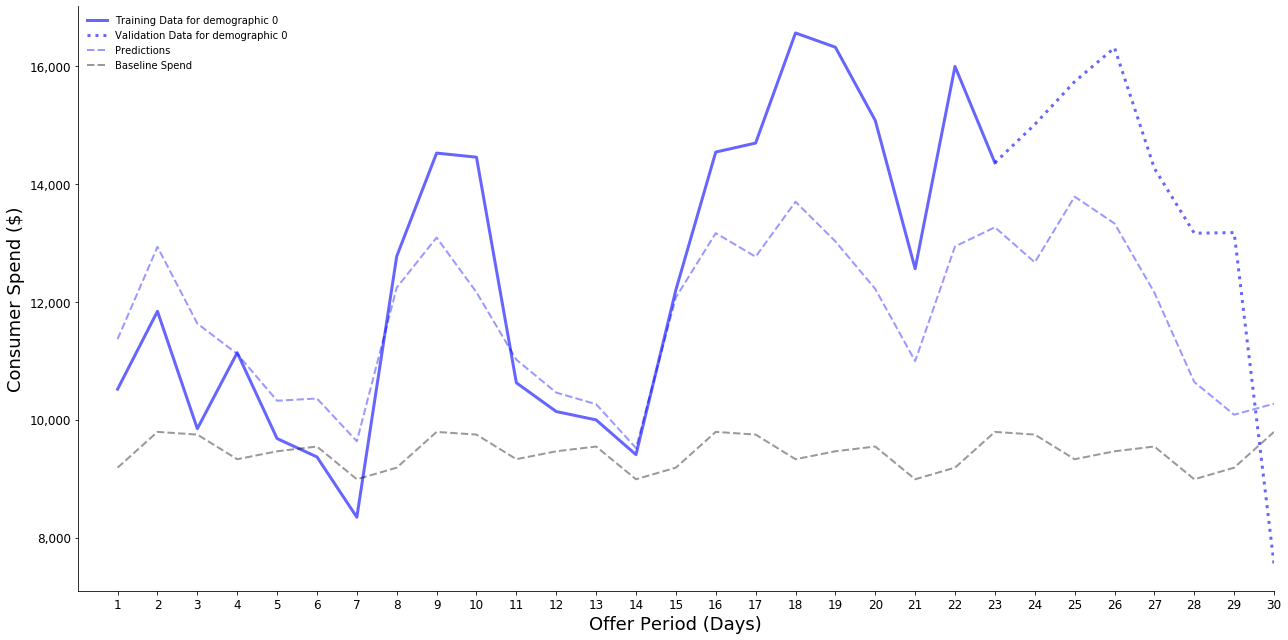

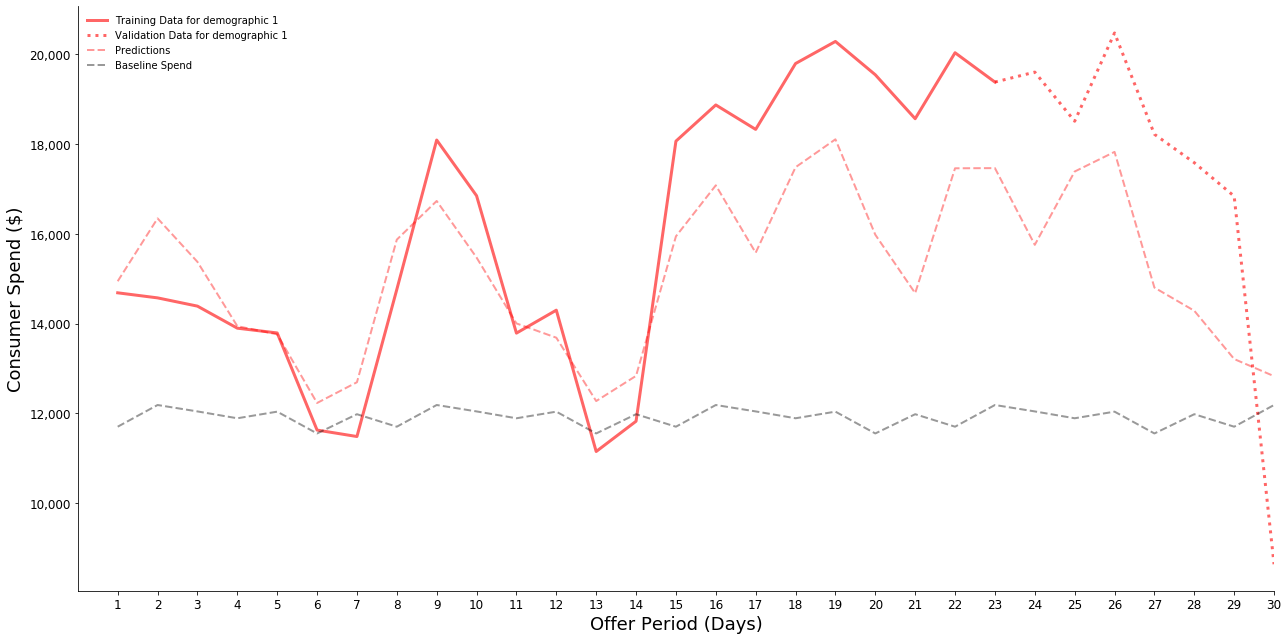

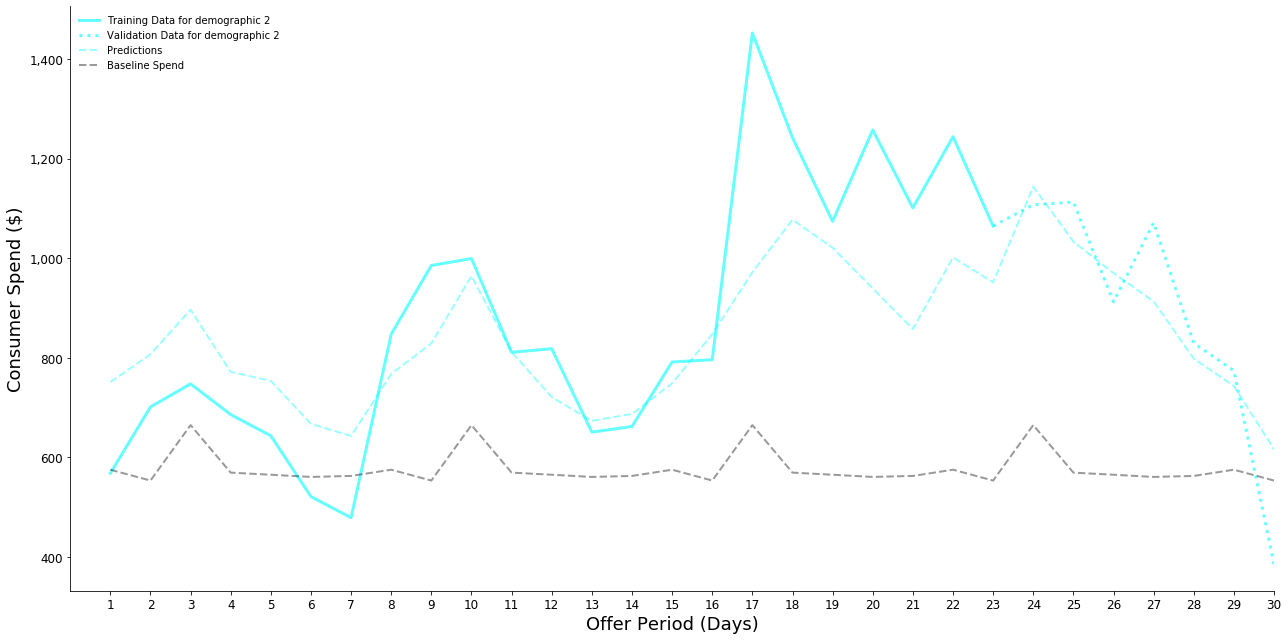

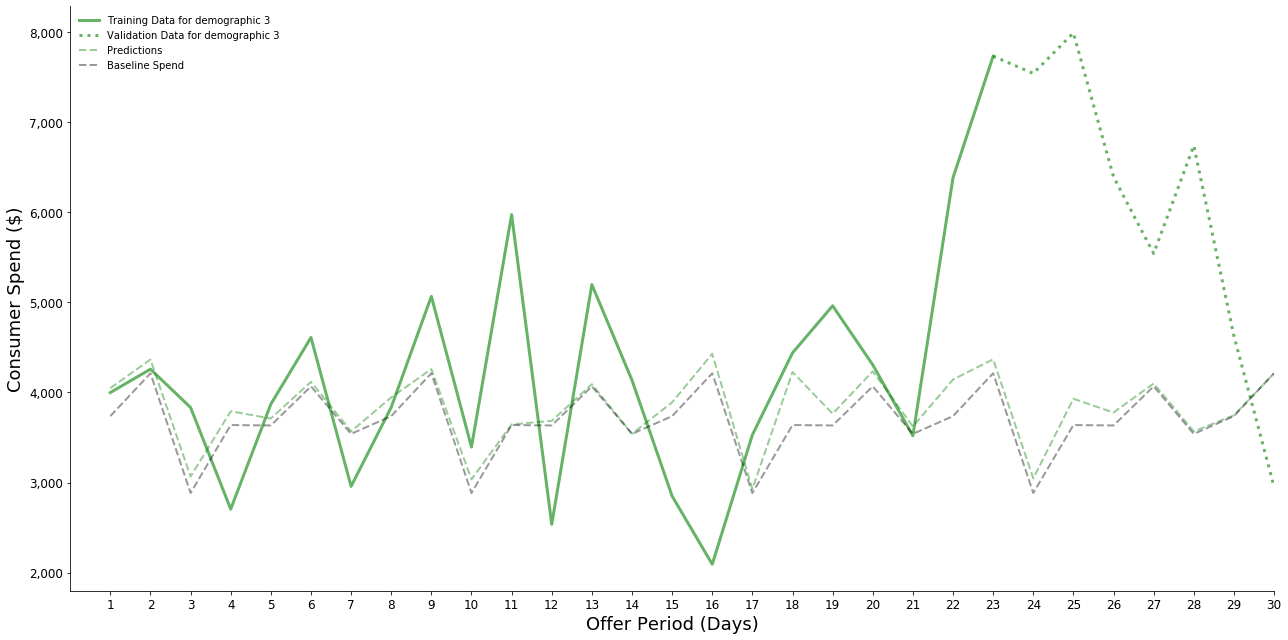

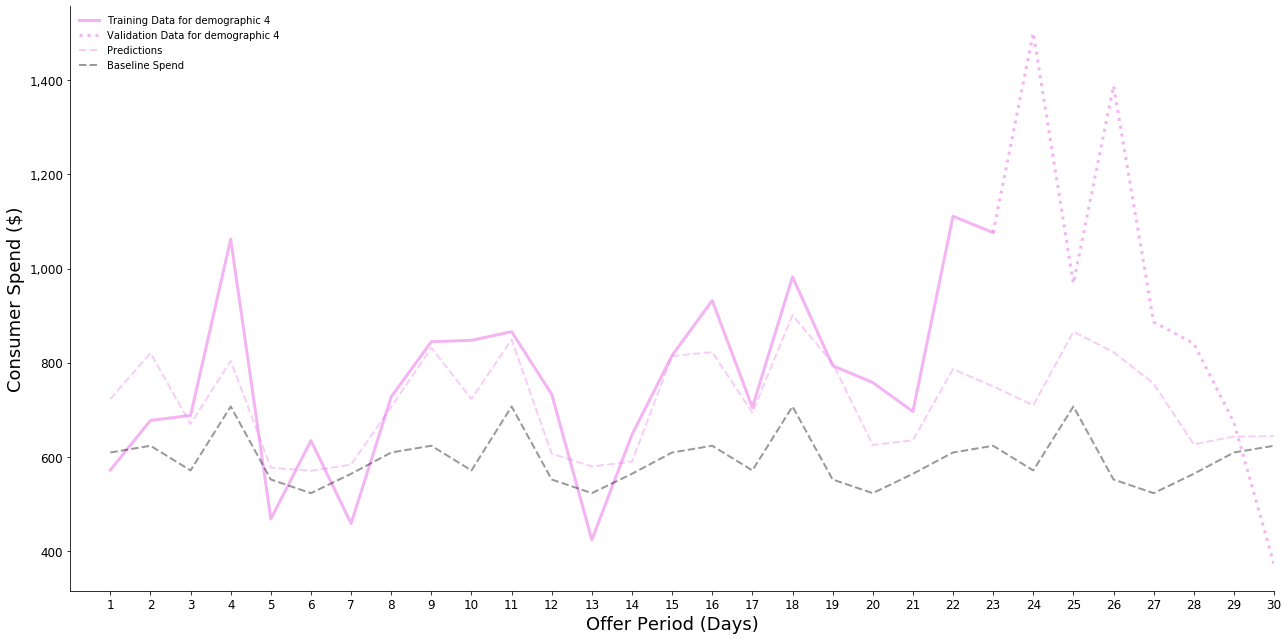

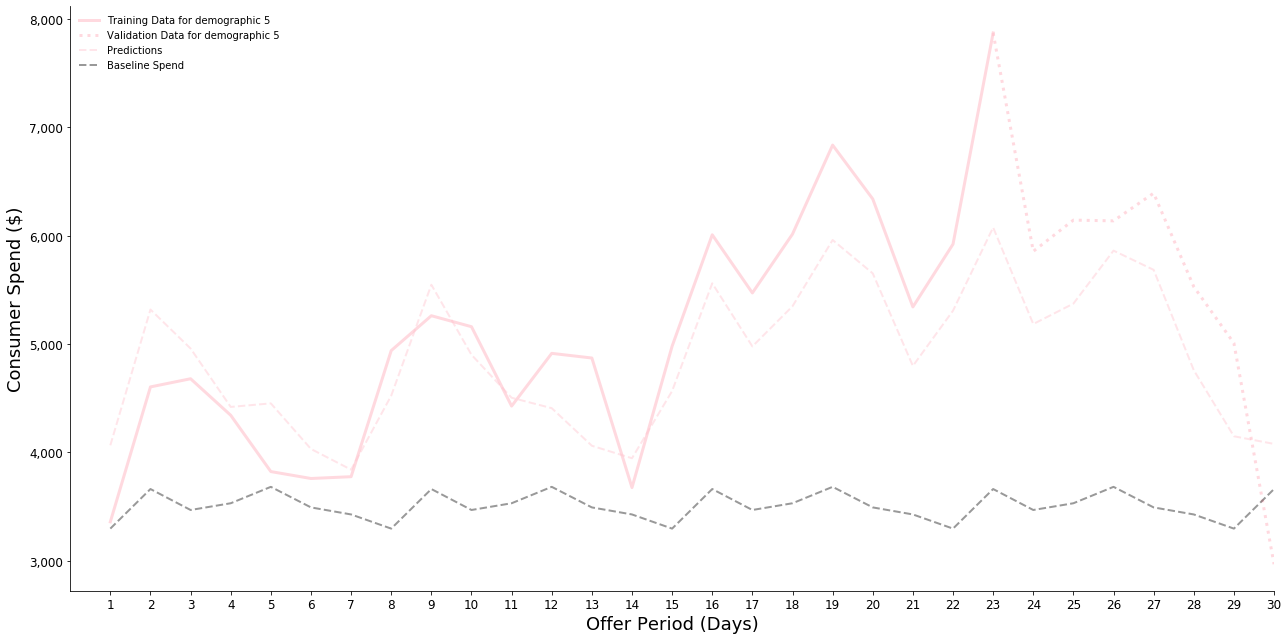

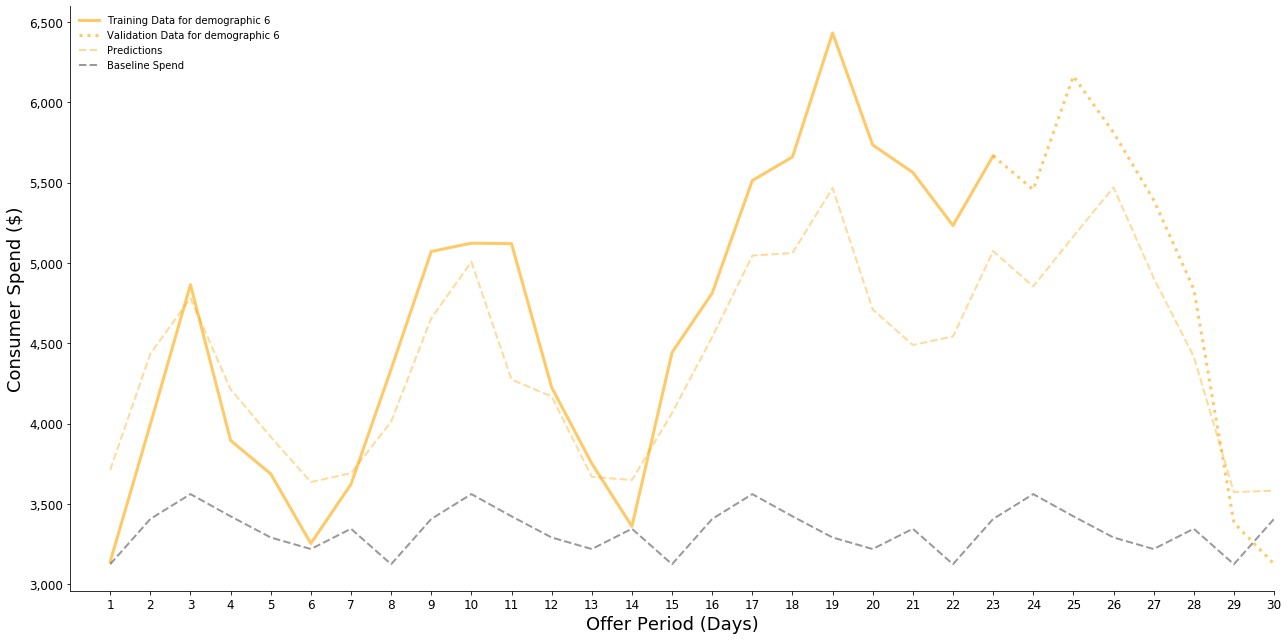

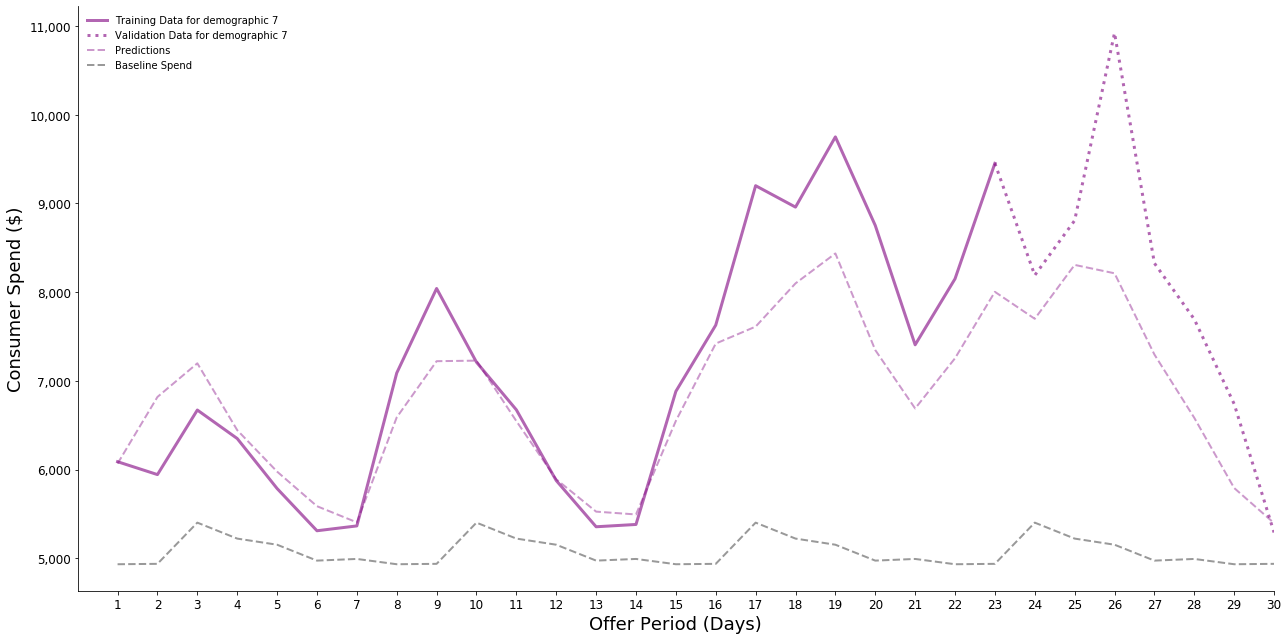

In [53]:
for demographic in [0,1,2,3,4,5,6,7]:
    # creates plot
    fig, ax = plt.subplots(figsize=(18,9))

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    plot_spend(input_data, demographic, colors[demographic])

    # show the plot legend
    ax.legend(loc=2, frameon=False)

    # set the x tick limits
    ax.set_xlim(0, 30)

    # set the x ticks
    ax.set_xticks(list(range(1,31)))

    # set x label
    ax.set_xlabel('Offer Period (Days)', fontsize=18)

    # set y label
    ax.set_ylabel('Consumer Spend ($)', fontsize=18)

    # set size of the axis params
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # Adds the comma into y labels
    ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    # show/close
    plt.show()

The above graphs show a number of interesting things about the modeling and how well it has worked. It shows that for the majority of the demographics the predictions follow a similar trend to the actual results and in most cases present a strong impression of how well the live marketing will perform. It is especially good to see that this prediction continues into the validation area as this shows the models should perform equally well on new or unknown data. 

The baseline level created just using the day of the week data gives an indication of how much extra revenue the marketing campaigns actually influenced. This could be used in future to calculate the most profitable campaigns and therefore help reduce costs and increase the effectiveness of the marketing.

It's also worth taking a look at the demographics where the model didn't perform very well. Demographic 3 was very difficult to predict as their seemed to be little correlation between spend and the number of influenced transactions. This shows that these users who are typically high spenders aren't really influenced to spend anymore due to the offers. It therefore would save money limit or send fewer offers to these users as they are likely to spend significant amounts of money regardless of the offers.

In [58]:
# for reference while performing the analysis
predictions.groupby('demographic').mean()

,female,male,other,unknown gender,age,income,total transactions,total spend,spend per trans,spend per day,membership length
demographic,,,,,,,,,,,
0,0.000000,1.000000,0.0,0.0,60.444397,81426.005133,6.438409,133.986044,22.092649,4.466201,75.070145
1,1.000000,0.000000,0.0,0.0,63.564690,86695.080863,5.924528,129.651910,23.028409,4.321730,87.980458
2,0.000000,0.000000,0.0,1.0,0.000000,0.000000,5.909179,13.574971,2.352779,0.452499,70.869565
3,0.502793,0.497207,0.0,0.0,56.983240,79050.279330,7.737430,778.432793,129.113700,25.947760,81.608939
4,0.000000,0.000000,1.0,0.0,54.507614,62649.746193,6.842640,96.963959,14.529618,3.232132,71.472081
5,0.000000,1.000000,0.0,0.0,47.616538,50965.775668,5.844617,32.549705,5.885533,1.084990,35.041469
6,0.032294,0.967706,0.0,0.0,49.905902,54699.331849,9.584076,58.356158,7.968539,1.945205,178.811804
7,1.000000,0.000000,0.0,0.0,50.883890,54023.584906,6.490203,60.831626,10.248875,2.027721,56.779753


### Project Improvements & Evaluation

The results above show a lot of promise and many more insights could gained from them already. However, there are also many improvements that could be made to the results if more time and data were given to the project. In this short section I will go through a few of the improvements that could be made:

- One of the biggest changes could be an additional model that calculates the chance of an actual transaction taking place and being influenced. This was originally in my scope of work for this project as currently it's not a true predict as currently I'm relying on the fact that I know what transactions will be influenced to predict spend. This third model would tie everything together but I found that in order to create a decent model we would potentially need much more training data than just one month of sales.


- A second improvement would be simply to get a much larger training set and adding variables around the actual products that users are buying. This would potentially add another layer to the predictions and would probably result in better results from the modeling.


- In a similar way I could have used more of the data behind the campaigns such as what format they are web, social etc. This could have improved the model as it would weight similar campaigns in a similar way.


- Finally, as mentioned in the first section a lot more analysis can be done with these models. I could loop through zeroing each campaign before performing a prediction, this would show which campaigns are most effective on each demographic. Or I could look further into when each campaign should be deployed as some demographics probably respond better to offers on different days (this is already shown by a varying baseline on the graphs above.

Using the two models and potentially a third (probability of transactions) could help Startbucks or any business improve marketing efficiency and profit. This shows how powerful ML can be for gaining key insights on the success of marketing campaigns. 